# 交通信息检测与处理
# 实验1：基于线圈数据的交通流密速分析

----

In [39]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import sklearn 
import os
import statsmodels

## 2, 3.1, 3.2 数据读取和冗余数据处理一并完成
----
将所有数据合并成一个csv读入，接着根据FSTR_LOOPGROUPID和FDT_TIME为索引进行均值聚合（对于速度的均值按照时间平均速度计算，虽然最后发现实际上没有区别），直接达到了去除冗余记录的目的。最后取出要求的NHNX40(1)检测器检测器的数据。	


In [40]:
# csv_name = os.listdir('./data')
# df = pd.DataFrame()
# for name in csv_name:
#     temp = pd.read_csv('./data/'+name)
#     df = pd.concat([df,temp], axis=0)
# df.to_csv('data.csv', index=False)
df = pd.read_csv('data.csv')
df['FINT_OCCUPY'] = df['FINT_OCCUPY']*0.01
df.head(5)
df.describe()
df.isnull().sum()
df.index
df_temp11 = df.groupby(['FSTR_LOOPGROUPID','FDT_TIME'])['FINT_VOLUME'].agg(['sum','count'])
df_temp11 = df_temp11.reset_index()
df = pd.merge(df,df_temp11,how='outer')
df

df['SPEED_AVG']=(df['FINT_VOLUME']*df['FINT_SPEED']*df['count'])/df['sum']
df = df.fillna(0)
df = df.groupby(['FSTR_LOOPGROUPID',
            'FDT_TIME'])['FINT_VOLUME',
                        'FINT_OCCUPY','SPEED_AVG'].agg(np.nanmean)
df = df.fillna(0)
df
df = df.loc['NHNX40(1)      ']
df
odf = pd.read_csv('data.csv')
odf = odf.groupby(['FSTR_LOOPGROUPID','FDT_TIME'])['FINT_SPEED'].agg(['mean'])
odf = odf.loc['NHNX40(1)      ']
odf
df.isnull().sum()
sum(sum([df['SPEED_AVG']==odf['mean']]))

C:\Users\SEELEA~1\AppData\Local\Temp/ipykernel_26804/3842534154.py:20: FutureWarning: Indexing with multiple keys (implicitly converted to a tuple of keys) will be deprecated, use a list instead.
  df = df.groupby(['FSTR_LOOPGROUPID',


30182

## 3.3 统计每天的记录数，得到每天的记录缺失个数

----
缺失是指按照固定间隔采集的记录中，某时刻的记录不存在。先生成一个要求的完整的时间序列，然后和原数据按并集规则，以时间列为索引进行融合，这样新的df中含有nan的行即为原来缺失的数据行。


In [41]:
df = df.reset_index()
df['FDT_TIME'] = pd.to_datetime(df['FDT_TIME'])
df
target_time = pd.date_range(start = '2010-04-18 00:00:00',
                            end = '2010-04-24 23:59:40',
                            freq='20S')
target_time = pd.DataFrame({'FDT_TIME':target_time})
target_time
df = pd.merge(target_time,df, on='FDT_TIME', how='outer')
df
df.isnull().sum()

FDT_TIME        0
FINT_VOLUME    58
FINT_OCCUPY    58
SPEED_AVG      58
dtype: int64

## 3.4 对于缺失数据，采用前三个周期的平均值代替

----
用for循环遍历df，检测到含nan行，就取前三行平均值填充，完毕后检查没有nan行。

In [15]:
df['FDT_TIME'] = 0
for i in range(len(df.index)):
    if  np.isnan(df['FINT_VOLUME'].iloc[i]):
        df.loc[i] = (df.loc[i-1]+df.loc[i-2]+df.loc[i-3])/3
df['FDT_TIME'] = target_time['FDT_TIME']
df.isnull().sum()

FDT_TIME       0
FINT_VOLUME    0
FINT_OCCUPY    0
SPEED_AVG      0
dtype: int64

## 4.编写数据聚集函数，实现返回不同时间间隔下的流量、速度和占有率
----
定义函数time_based_group，输入一个数据框和要求的聚合时间间隔，返回聚合后的新数据框。

接着按照新的间隔数对时间列分桶，将分桶结果设为TIME_BINS列，再按它对df进行均值聚合。和先前一样，按照时间平均速度的方法单独计算平均速度。

In [17]:
def time_based_group(df=df.copy(), gap_s=20):
    
    q = int(len(df)/(gap_s/20))
    df['TIME_BINS'] = pd.qcut(df.FDT_TIME,q=q,labels =range(q))
    df['FINT_VOLUME'] = df['FINT_VOLUME']*(3600/20)
    df_temp11 = df.groupby(['TIME_BINS'])['FINT_VOLUME'].agg(['sum','count'])
    df_temp11 = df_temp11.reset_index()
    df = pd.merge(df,df_temp11,how='outer')
    
    df['SPEED_AVG']=(df['FINT_VOLUME']*df['SPEED_AVG']*df['count'])/df['sum']
    df = df.fillna(0)
    df = df.groupby(['TIME_BINS'])[['FINT_VOLUME',
                            'FINT_OCCUPY','SPEED_AVG']].agg(np.nanmean)
    df = df.fillna(0)
    return df

## 5.1 分别基于20s， 5min，15min的所有数据，绘制V-O, V-Q, O-Q散点图

----
使用上面的定义的聚合函数，分别得到了粒度为20s,300s,900s的数据框，接下来只要对它们分别作要求的V-O, V-Q, Q-O散点图就可以了。

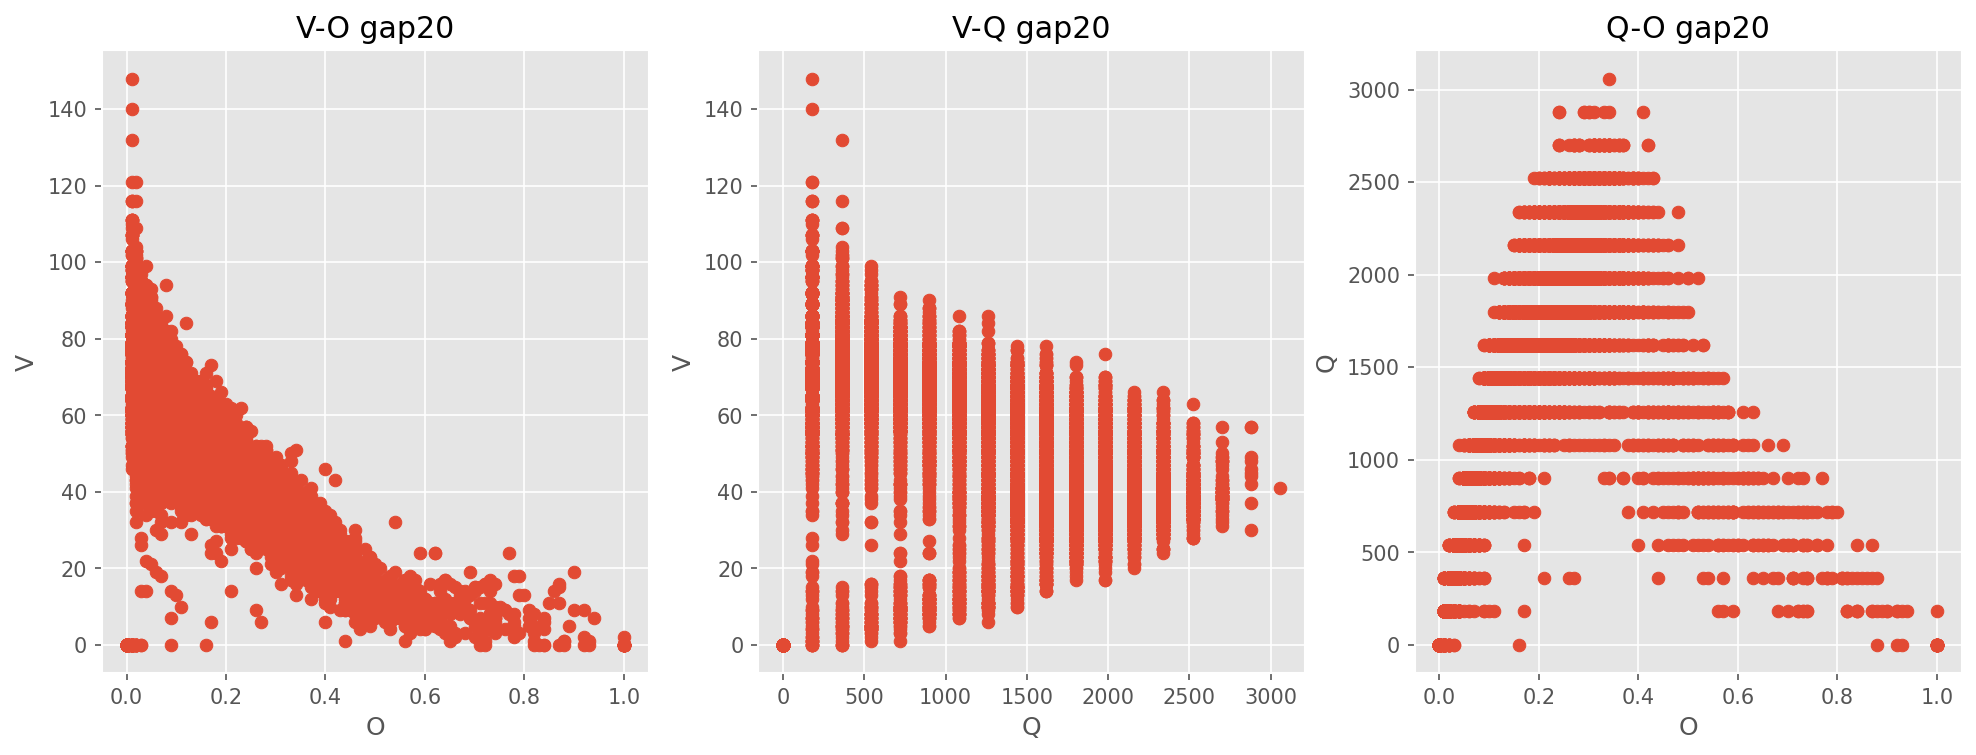

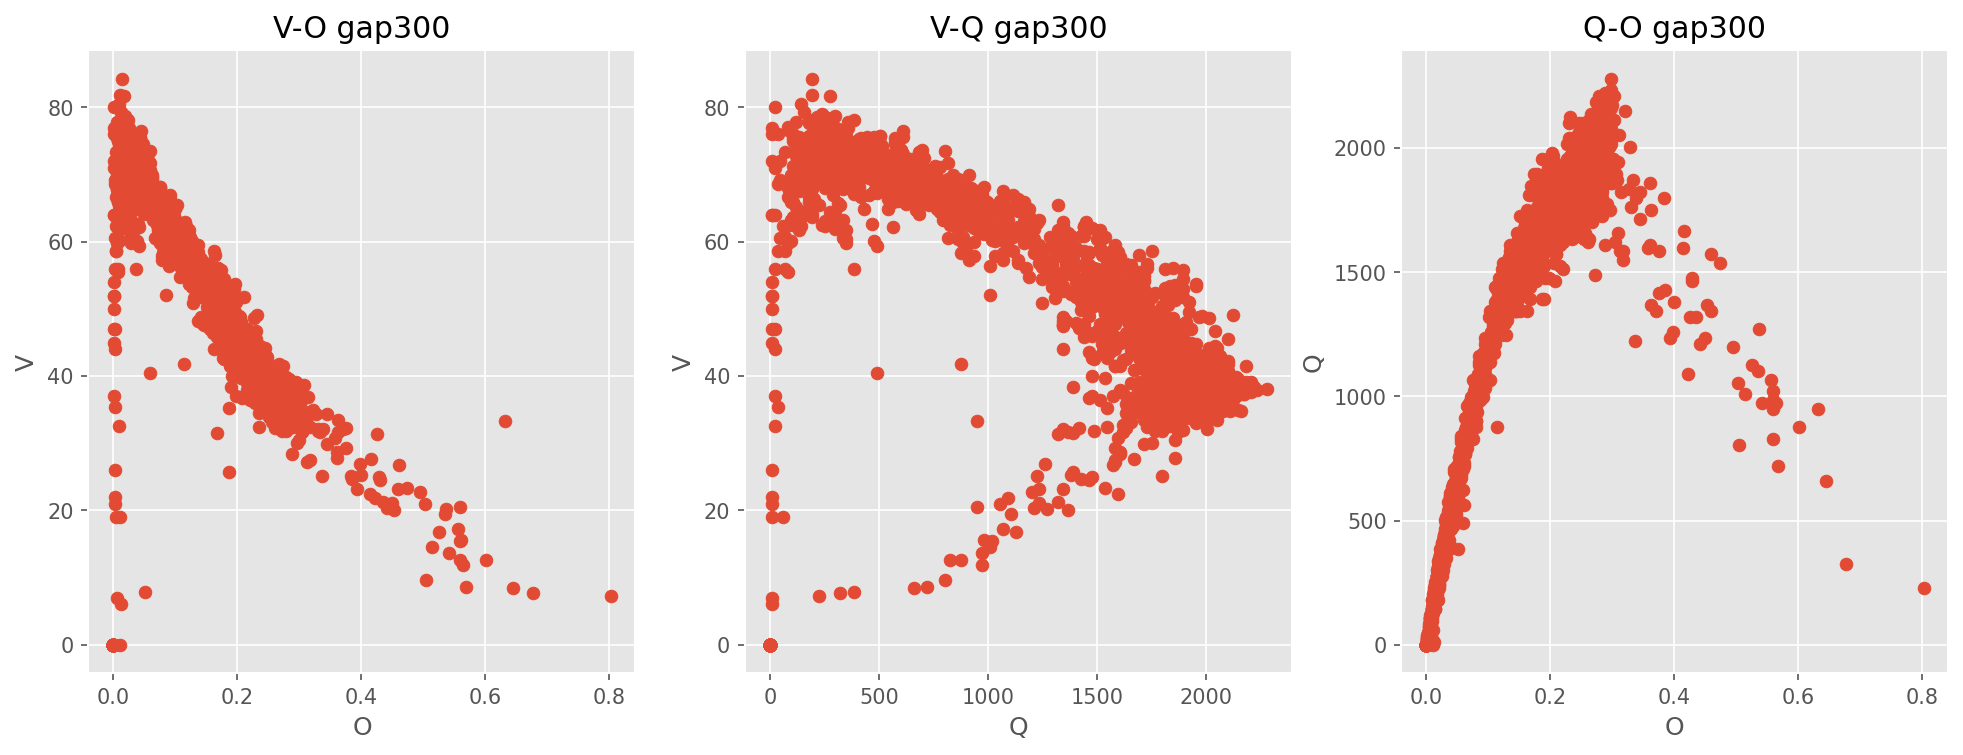

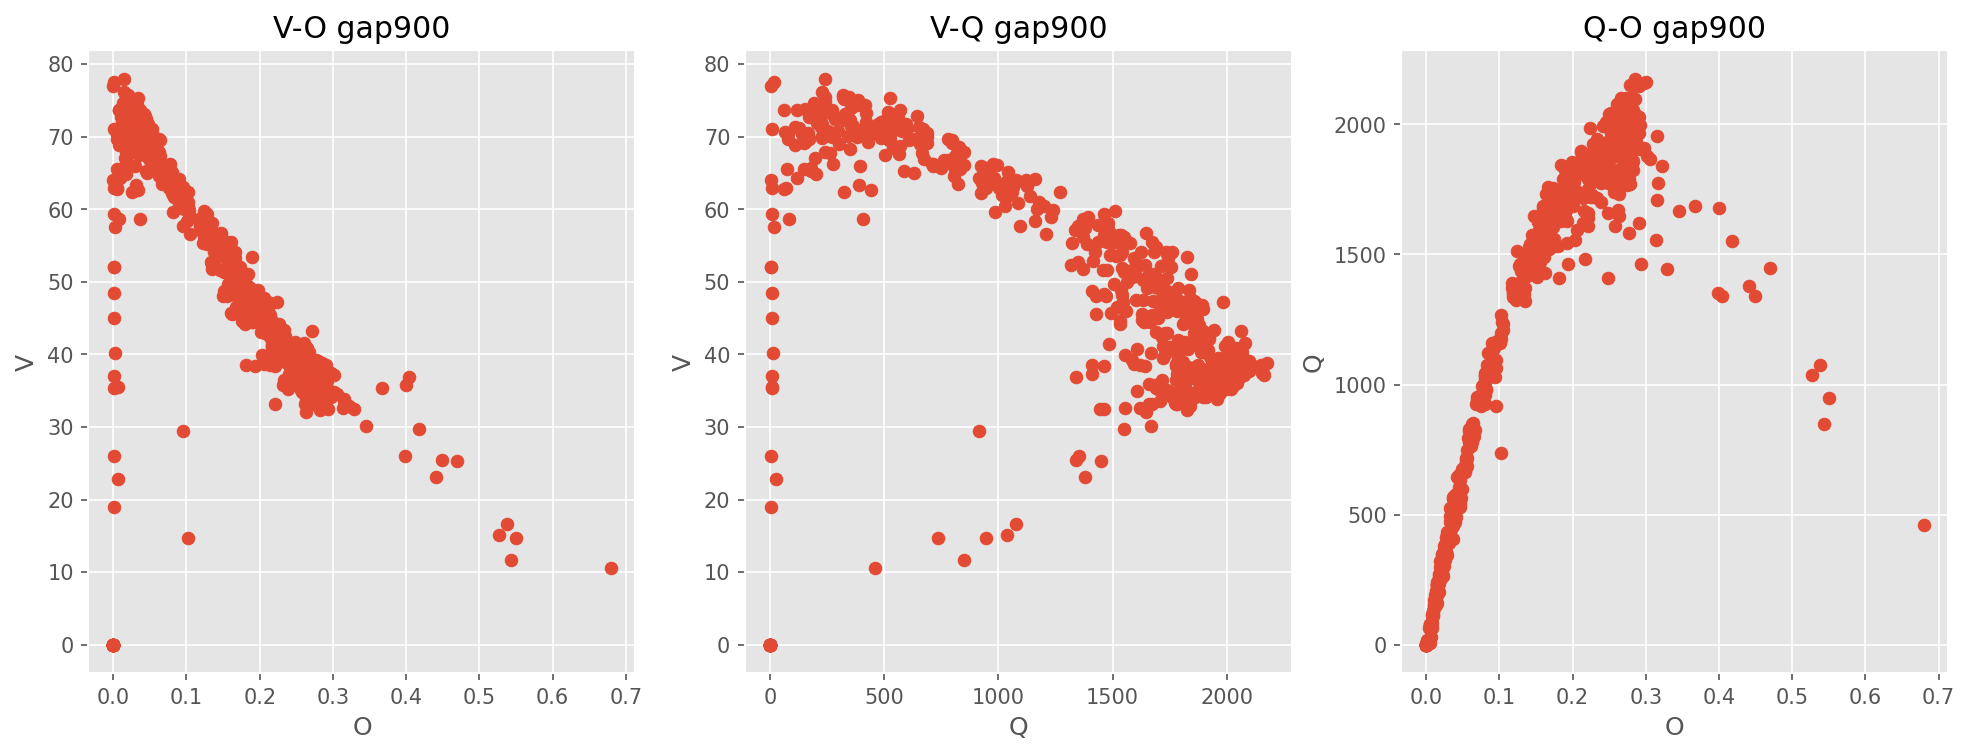

In [42]:
def plot_tri(df=df.copy(), gap_s=20):
    df_subsampled = time_based_group(df=df, gap_s=gap_s)
    V = np.array(df_subsampled['SPEED_AVG'])
    Q = np.array(df_subsampled['FINT_VOLUME'])
    O = np.array(df_subsampled['FINT_OCCUPY'])
    plt.figure(dpi=150, figsize=[16,5.5])
    plt.style.use('ggplot')
    
    plt.subplot(1,3,1)
    plt.scatter(O,V)
    plt.title('V-O gap'+str(gap_s))
    plt.xlabel('O')
    plt.ylabel('V')
    
    plt.subplot(1,3,2)
    plt.scatter(Q,V)
    plt.title('V-Q gap'+str(gap_s))
    plt.xlabel('Q')
    plt.ylabel('V')
    
    plt.subplot(1,3,3)
    plt.scatter(O,Q)
    plt.title('Q-O gap'+str(gap_s))
    plt.xlabel('O')
    plt.ylabel('Q')

plot_tri(df.copy(),20)
plot_tri(df.copy(),300)
plot_tri(df.copy(),900)

## 5.2 基于5min数据的图，估计通行能力、自由流车速、最佳占有率、最佳车速、阻塞占有率

----


通过观察粒度为900s的图，可以得到如下结果：

    通行能力：2250veh/h

    自由流车速： 80km/h

    最佳占有率： 0.3

    最佳车速： 38km/h

    阻塞占有率：0.7

## 5.3 基于5min的O-V的数据，移除明显的异常数据，建立占有率O和速度V的线性回归模型，给出关系式，并对模型参数进行统计检验

----
根据上面的图，确定三批异常点，位置分别是(O>0.6 & V>20), (O>0.7), (O<0.1 & V<60).因此按照这个标准将它们清除。

接着用线性回归模型建立V=f(O)的关系，并进行统计检验。

可以看到回归结果为：

V =  73.26221028 + (-131.54459282) * O 

两个参数检验P值都为0，认为回归结果是可信的。

In [43]:
df_300 = time_based_group(df=df.copy(), gap_s=300)
df_300.loc[(np.array(df_300.FINT_OCCUPY)>0.6) & (np.array(df_300.SPEED_AVG)>25)]
to_drop = df_300.loc[(np.array(df_300.FINT_OCCUPY)<0.1) & (np.array(df_300.SPEED_AVG)<60)].index
df_300.loc[(np.array(df_300.FINT_OCCUPY)>0.7)]
df_300.drop([788,789]+list(to_drop), axis=0, inplace=True)
V = np.array(df_300['SPEED_AVG'])
Q = np.array(df_300['FINT_VOLUME'])
O = np.array(df_300['FINT_OCCUPY'])
import statsmodels.api as sm
O = sm.add_constant(O)
model = sm.OLS(V,O)
results = model.fit()
results.params

array([  73.23250928, -131.51860378])

In [44]:
results.pvalues

array([0., 0.])

In [45]:
results.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                      y   R-squared:                       0.941
Model:                            OLS   Adj. R-squared:                  0.941
Method:                 Least Squares   F-statistic:                 2.988e+04
Date:                Fri, 05 Nov 2021   Prob (F-statistic):               0.00
Time:                        21:52:56   Log-Likelihood:                -5097.7
No. Observations:                1888   AIC:                         1.020e+04
Df Residuals:                    1886   BIC:                         1.021e+04
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const         73.2325      0.159    461.280      0.000      72.921      73.544
x1          -131.5186      0.761   -172.851      0.000    -133.011    -130.026
==============================================================================
Omnibus:                      298.476   Durbin-Watson:                   0.867
Prob(Omnibus):                  0.000   Jarque-Bera (JB):             2347.047
Skew:                           0.503   Prob(JB):                         0.00
Kurtosis:                       8.369   Cond. No.                         9.47
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

## 5.4 选择第一天数据

----
### 5.4.1分别绘制流量、速度、占有率时序图
在同一张图中包含某变量的20s、5min和15min间隔下的变化曲线，对图表进行讨论。（讨论内容参考：高峰时段分布，不同时间分辨率时三组曲线之间的异同点等）

综合三组图，可以认为流量高，占有率高，速度较低的时间段为高峰时段，因此判断约为13点到21点为高峰时段。

在不同时间分辨率下，观察三组曲线，可以发现粒度20s的曲线波动剧烈，其变化趋势观察不容易。而这一情况在粒度改变到300s或900s时显著改善，且同样地，300s的曲线相比900s也在局部保持了更多波动细节。此外，三组数据在深夜和凌晨都表现出较强的不稳定性，这是因为夜间样本较少，没有形成比较连续的交通流，不便于分析其流密速关系。

In [26]:
df_day1 = df[:int(len(df)/7)]
df_day1_20 = time_based_group(df = df_day1.copy(), gap_s=20)
df_day1_300 = time_based_group(df = df_day1.copy(), gap_s=300)
df_day1_900 = time_based_group(df = df_day1.copy(), gap_s=900)

df_day1_20 = df_day1_20.reset_index()
df_day1_20['hue'] = ['20S' for i in range(len(df_day1_20))]
df_day1_300 = df_day1_300.reset_index()
df_day1_300['TIME_BINS'] = np.array(df_day1_300['TIME_BINS'])*15
df_day1_300['hue'] = ['300S' for i in range(len(df_day1_300))]
df_day1_900 = df_day1_900.reset_index()
df_day1_900['TIME_BINS'] = np.array(df_day1_900['TIME_BINS'])*45
df_day1_900['hue'] = ['900S' for i in range(len(df_day1_900))]
df_plot = pd.concat([df_day1_20,df_day1_300])
df_plot = pd.concat([df_plot,df_day1_900])
df_plot = df_plot.reset_index()
df_plot

Text(0.5, 1.0, 'volume')

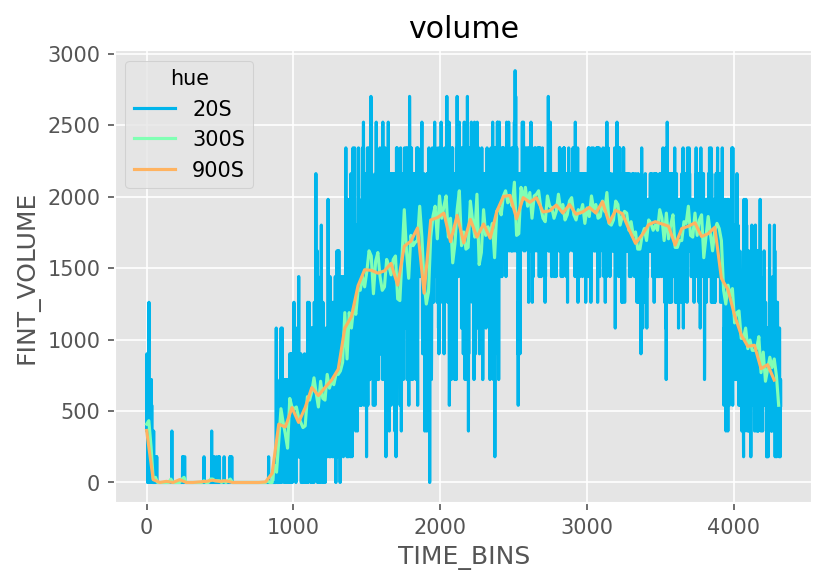

In [29]:
plt.figure(dpi=150)
plt.style.use('ggplot')
sns.lineplot(data=df_plot,x='TIME_BINS',
        y='FINT_VOLUME',hue='hue',
        palette='rainbow')
# plt.ylim([0,17.5])
plt.title('volume')


Text(0.5, 1.0, 'occupy')

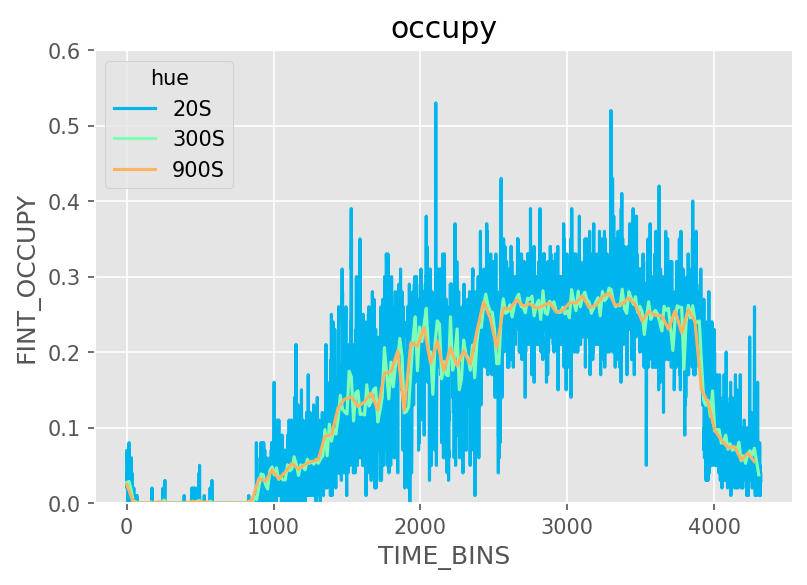

In [30]:
plt.figure(dpi=150)
plt.style.use('ggplot')
sns.lineplot(data=df_plot,x='TIME_BINS',y='FINT_OCCUPY',hue='hue',
        palette='rainbow')
plt.ylim([0,0.6])
plt.title('occupy')

Text(0.5, 1.0, 'speed')

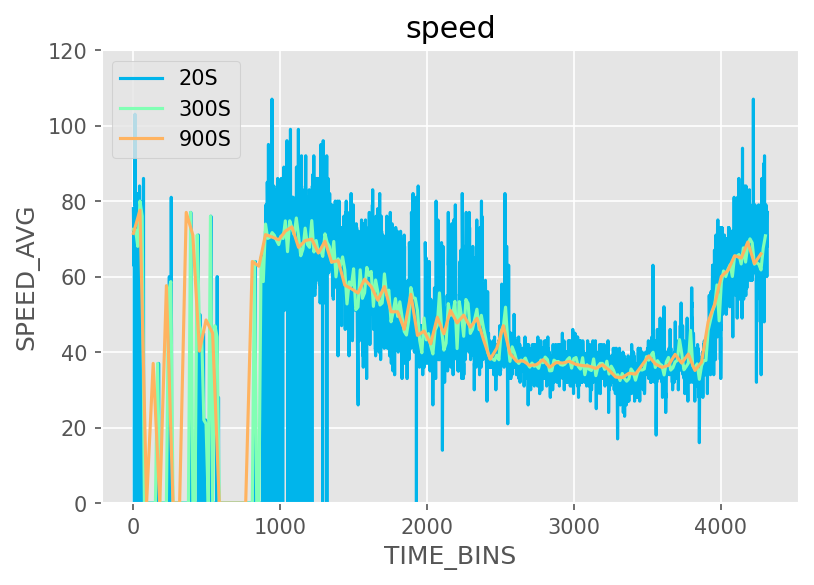

In [31]:
plt.figure(dpi=150)
plt.style.use('ggplot')
sns.lineplot(data=df_plot,x='TIME_BINS',y='SPEED_AVG',hue='hue',
        palette='rainbow')
plt.ylim([0,120])
plt.legend(loc = 'upper left')
plt.title('speed')

In [32]:
plot_df2 = pd.DataFrame()
plot_df2['TIME_BINS'] = pd.concat([df_day1_900['TIME_BINS'],df_day1_900['TIME_BINS']])
plot_df2['plot'] = pd.concat([df_day1_900['FINT_VOLUME'],df_day1_900['SPEED_AVG']])
plot_df2['hue'] = np.append(['volume' for i in range(len(df_day1_900))],['speed'for i in range(len(df_day1_900))])
plot_df2

,TIME_BINS,plot,hue
0,0,364.000000,volume
1,45,20.000000,volume
2,90,0.000000,volume
3,135,8.000000,volume
4,180,0.000000,volume
...,...,...,...
91,4095,65.525210,speed
92,4140,64.908333,speed
93,4185,69.155779,speed
94,4230,63.446602,speed


### 5.4.2基于15min数据，绘制流量-速度时变图
说明二者的变化关系（即在同一张图中包含流量随时间变化的曲线和速度随时间变化的曲线，两条曲线分别采用左右两个纵坐标）

显然，在日间连续交通流中，速度和流量呈现一定的负相关关系，当流量升高时，道路变得更加拥堵，车速也因此下降。这也说明道路基本上还没有出现严重堵塞的状况。

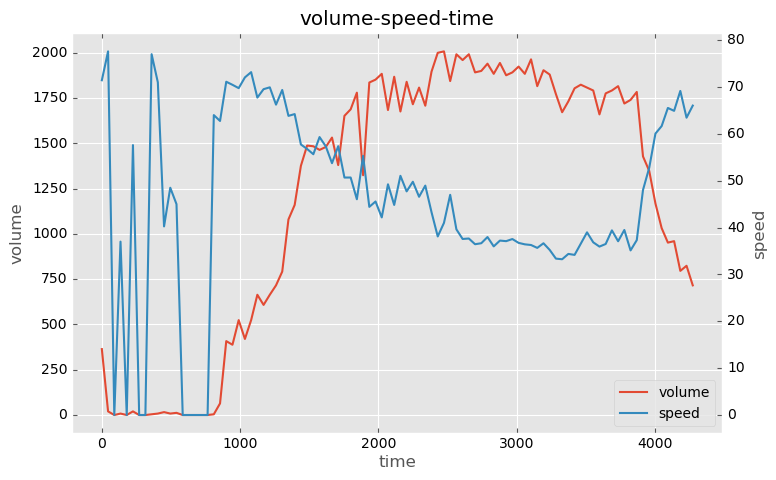

In [33]:
from mpl_toolkits.axisartist.parasite_axes import HostAxes, ParasiteAxes
import matplotlib.pyplot as plt
plt.style.use('ggplot')
plt.figure(dpi=100,figsize=[10,5])
fig = plt.figure(1)

host = HostAxes(fig, [0.15, 0.1, 0.65, 0.8])
par1 = ParasiteAxes(host, sharex=host)
host.parasites.append(par1)

host.set_ylabel('volume')
host.set_xlabel('time')

host.axis['right'].set_visible(False)
par1.axis['right'].set_visible(True)
par1.set_ylabel('speed')

par1.axis['right'].major_ticklabels.set_visible(True)
par1.axis['right'].label.set_visible(True)

fig.add_axes(host)

# host.set_xlim(0,2)
# host.set_ylim(0,2)

# host.set_xlabel('Distance')
# host.set_ylabel('Density')
# host.set_ylabel('Temperature')

p1, = host.plot(df_day1_900.TIME_BINS, df_day1_900.FINT_VOLUME, label="volume")
p2, = par1.plot(df_day1_900.TIME_BINS, df_day1_900.SPEED_AVG, label="speed")

# par1.set_ylim(0,4)
plt.title('volume-speed-time')
host.legend(loc = 'lower right')
# #轴名称，刻度值的颜色
# host.axis['left'].label.set_color(p1.get_color())
# par1.axis['right'].label.set_color(p2.get_color())
# par2.axis['right2'].label.set_color(p3.get_color())
# par2.axis['right2'].major_ticklabels.set_color(p3.get_color()) #刻度值颜色
# par2.axis['right2'].set_axisline_style('-|>',size=1.5) #轴的形状色
# par2.axis['right2'].line.set_color(p3.get_color()) #轴的颜色

### 5.4.3基于15min的数据 
估计车辆平均有效长度绘制车长的时序图绘制车长的分布

In [35]:
L = (df_day1_900['FINT_OCCUPY']*(df_day1_900['SPEED_AVG'])/3.6)/(df_day1_900['FINT_VOLUME']/3600)
df_day1_900['L'] = L
df_day1_900 = df_day1_900.fillna(0)
df_day1_900

,TIME_BINS,FINT_VOLUME,FINT_OCCUPY,SPEED_AVG,hue,L
0,0,364.0,0.024667,71.439560,900S,4.841142
1,45,20.0,0.001111,77.600000,900S,4.311111
2,90,0.0,0.000000,0.000000,900S,0.000000
3,135,8.0,0.000444,37.000000,900S,2.055556
4,180,0.0,0.000000,0.000000,900S,0.000000
...,...,...,...,...,...,...
91,4095,952.0,0.073333,65.525210,900S,5.047460
92,4140,960.0,0.074667,64.908333,900S,5.048426
93,4185,796.0,0.057111,69.155779,900S,4.961763
94,4230,824.0,0.066000,63.446602,900S,5.081888


Text(0.5, 1.0, 'Average Vehicle Length')

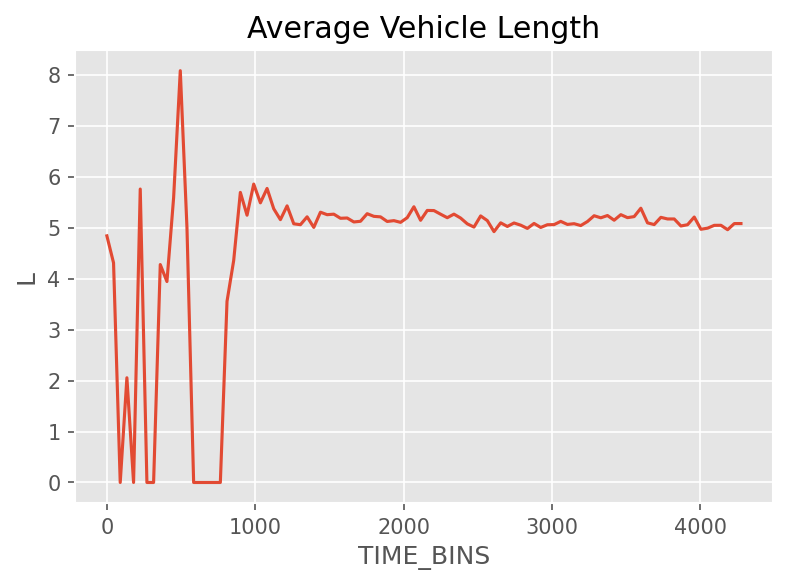

In [36]:
plt.figure(dpi=150)
plt.style.use('ggplot')
sns.lineplot(data=df_day1_900,x='TIME_BINS',y='L')
# plt.ylim([0,17.5])
plt.title('Average Vehicle Length')

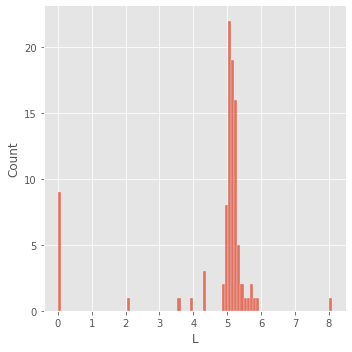

In [48]:
sns.displot(df_day1_900.L)